## NEP_Polar_snapshot

In [1]:
from ase.io import read
from ase.neighborlist import neighbor_list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])

def calculate_order_parameter(atoms, central_element='Ge', neighboring_element='Te'):
    cell = atoms.get_cell()
    distances = atoms.get_all_distances(mic=True)
    positions = atoms.get_positions()
    
    i_list, j_list = neighbor_list('ij', atoms, 4)
    central_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == central_element]
    neighboring_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == neighboring_element]
    
    polarization_vectors = []
    for central_atom in central_atoms:
        neighbors = [(j_list[k], distances[central_atom, j_list[k]]) for k in range(len(i_list)) if i_list[k] == central_atom and j_list[k] in neighboring_atoms]
        neighbors = sorted(neighbors, key=lambda x: x[1])[:6]
        nearest_neighbors = [index for index, _ in neighbors]
        central_position = positions[central_atom]
        neighbor_positions = positions[nearest_neighbors]
        displacements = neighbor_positions - central_position
        displacements -= np.round(displacements @ np.linalg.inv(cell)) @ cell
        neighbor_positions = central_position + displacements
        center_of_mass = np.mean(neighbor_positions, axis=0)
        polarization_vector = central_position - center_of_mass
        polarization_vectors.append(polarization_vector)
    tau = np.sum(polarization_vectors, axis=0)
    
    return tau / len(central_atoms), np.linalg.norm(tau) / len(central_atoms)


In [2]:
atoms = read('../split_xyz_files/split_800.xyz', index=-1)
central_element='Ge'
neighboring_element='Te'

cell = atoms.get_cell()
distances = atoms.get_all_distances(mic=True)
positions = atoms.get_positions()

i_list, j_list = neighbor_list('ij', atoms, 4)
central_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == central_element]
neighboring_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == neighboring_element]

central_positions = []
polarization_vectors = []
for central_atom in central_atoms:
    neighbors = [(j_list[k], distances[central_atom, j_list[k]]) for k in range(len(i_list)) if i_list[k] == central_atom and j_list[k] in neighboring_atoms]
    neighbors = sorted(neighbors, key=lambda x: x[1])[:6]
    nearest_neighbors = [index for index, _ in neighbors]
    central_position = positions[central_atom]
    neighbor_positions = positions[nearest_neighbors]
    displacements = neighbor_positions - central_position
    displacements -= np.round(displacements @ np.linalg.inv(cell)) @ cell
    neighbor_positions = central_position + displacements
    center_of_mass = np.mean(neighbor_positions, axis=0)
    polarization_vector = central_position - center_of_mass
    polarization_vectors.append(polarization_vector)
    central_positions.append(central_position)
    
polarization_vectors = np.array(polarization_vectors)
central_positions = np.array(central_positions)

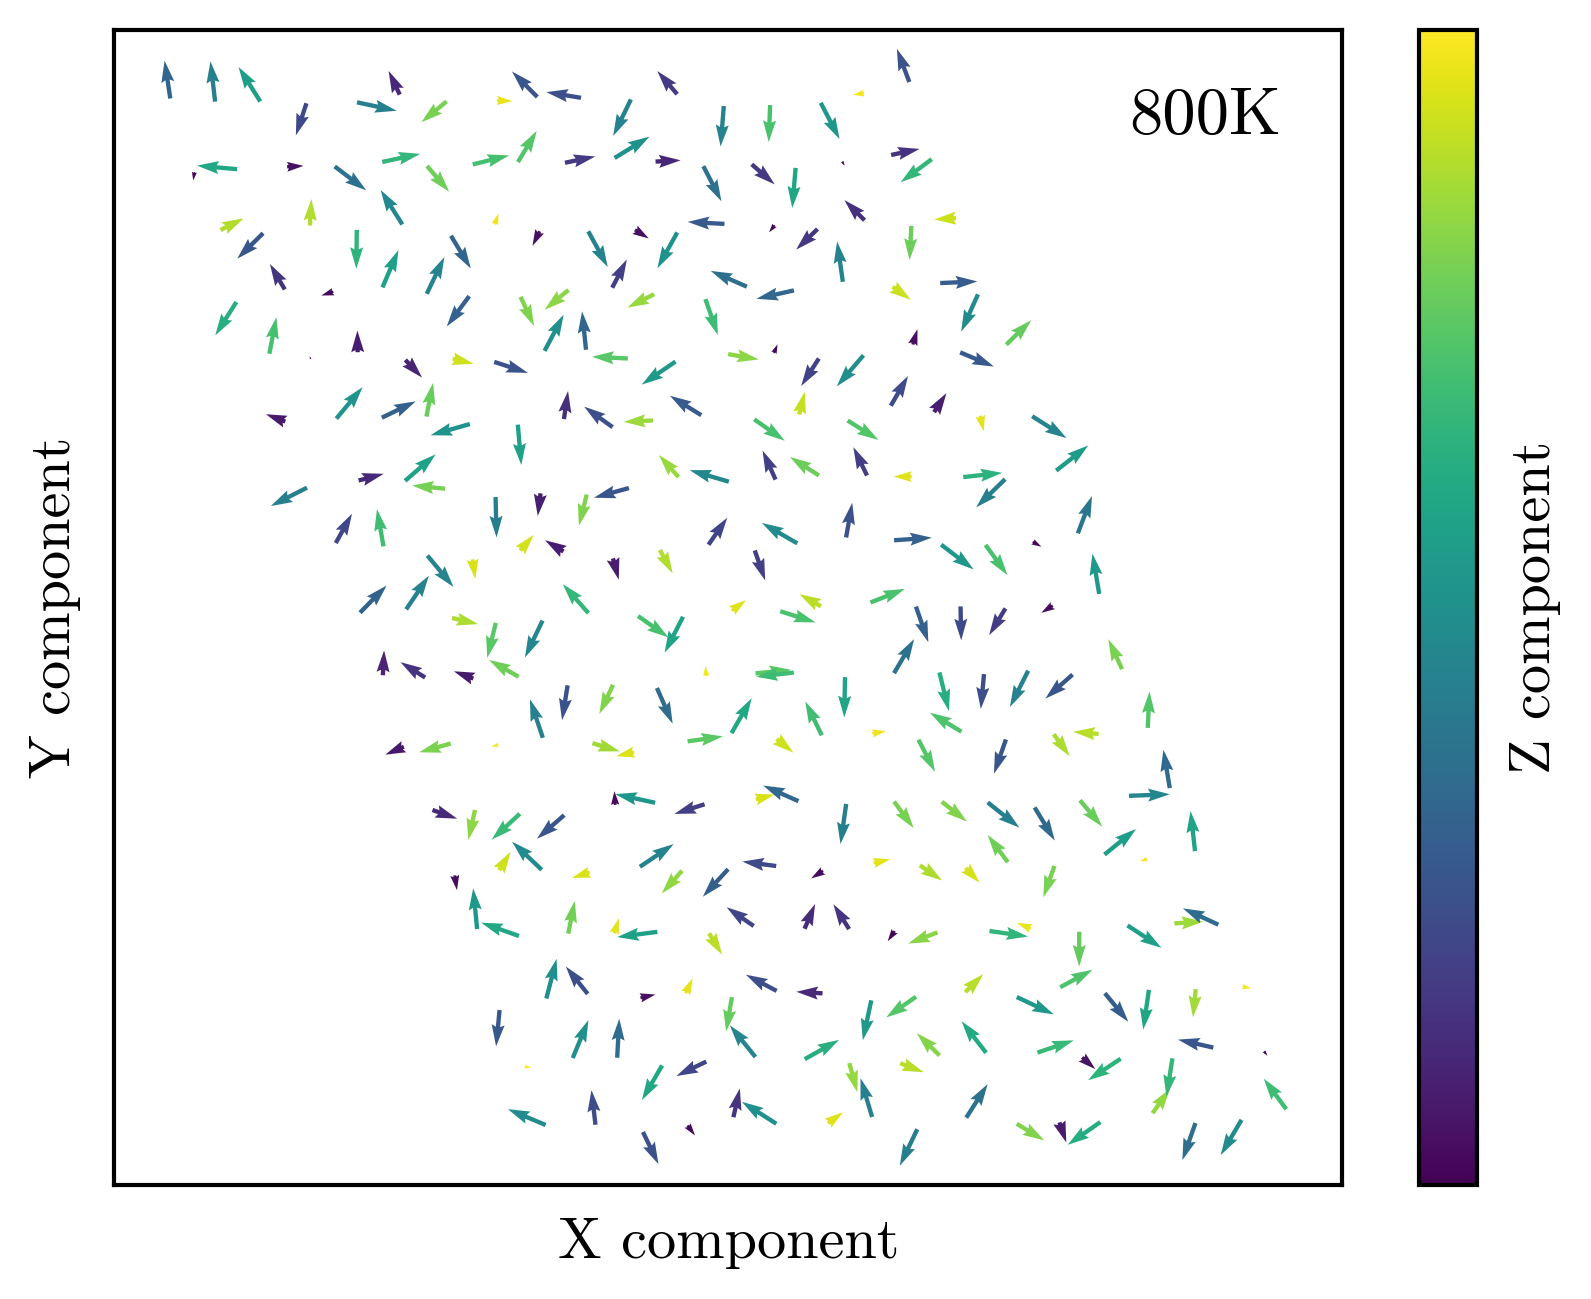

In [3]:
magnitudes = np.linalg.norm(polarization_vectors, axis=1)
normalized_vectors = polarization_vectors / magnitudes[:, np.newaxis]

u = np.array(normalized_vectors[:, 0])
v = np.array(normalized_vectors[:, 1])
w = np.array(normalized_vectors[:, 2])

x = np.array(central_positions[:, 0])
y = np.array(central_positions[:, 1])

color = w
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1)

plt.quiver(x, y, u, v, color, cmap=cmap, norm=norm, scale=30, pivot='tail', minlength=0.5)
plt.text(0.95, 0.95, "800K", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right')
cbar = plt.colorbar()
cbar.set_label('Z component', fontsize=plt.rcParams['font.size']-1)
cbar.set_ticks([])
plt.xlabel('X component', fontsize=plt.rcParams['font.size']-1)
plt.ylabel('Y component', fontsize=plt.rcParams['font.size']-1)
plt.xticks([])
plt.yticks([])
plt.savefig("snapshot_800K.png", bbox_inches='tight')